In [ ]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from operator import itemgetter
from sklearn.decomposition import NMF
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.nmf import Nmf
import pickle

In [ ]:
# Run the utilty functions from the seperate notebook
%run '/content/drive/MyDrive/Colab Notebooks/misc_functions.ipynb'

# DATA ANALYSIS

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/articles.csv')
len(data)

337

In [ ]:
data.head(5)

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


In [ ]:
data.head(5)

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


<ipython-input-47-ba575abd0dba>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['length_text'], color="r")


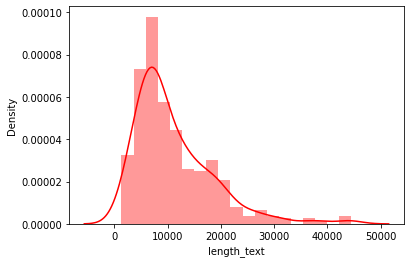

In [ ]:
data['length_text'] = data['text'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

<ipython-input-46-45dc6c278b63>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['length_title'], color="r")


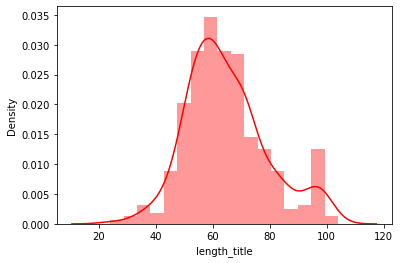

In [ ]:
data['length_title'] = data['title'].str.len()
sns.distplot(data['length_title'], color="r")
plt.show()

<Axes: >

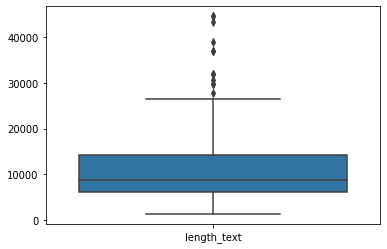

In [ ]:
sns.boxplot(data=data[["length_text"]])
# plt.show()

In [ ]:
# Get the word count
data['length_text'].mean()

11120.160237388724

In [ ]:
titles = [x for x in data['title']]
docs = [x for x in data['text']]

In [ ]:
print(len(data['text']))

337


# TEXT PREPROCESSING

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text.lower())
        words = text.split(" ")
        words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
        words = [re.sub('\s+', ' ', sent) for sent in words]
        words = [re.sub("\'", "", sent) for sent in words]
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
df=pd.DataFrame(columns=["doc"])
for i in range(len(data['text'])):
  df.loc[len(df.index)] = [str(preprocess(data['text'][i]))]

print(df)
df.to_csv("docs.csv")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/docs.csv')

In [ ]:
df.head()

,Unnamed: 0,docid,title,doc
0,0,0,Chatbots were the next big thing: what happene...,"['headlin', 'blare', 'chatbot', 'next', 'thing..."
1,1,1,Python for Data Science: 8 Concepts You May Ha...,"['ever', 'find', 'look', 'question', 'concept'..."
2,2,2,Automated Feature Engineering in Python – Towa...,"['machin', 'learn', 'increas', 'move', 'hand',..."
3,3,3,Machine Learning: how to go from Zero to Hero ...,"['understand', 'machin', 'learn', 'question', ..."
4,4,4,Reinforcement Learning from scratch – Insight ...,"['want', 'learn', 'appli', 'artifici', 'intell..."


In [ ]:
docs=[x for x in df["doc"]]
titles=[x for x in df["title"]]

In [ ]:
# print(docs[0].strip("[]").replace("'", '').split(", "))

for i in range(len(docs)):
  docs[i]=docs[i].strip("[]").replace("'", '').split(", ")



In [ ]:
df.rename(columns = {'Unnamed: 0':'docid'}, inplace = True)
df.head()

,docid,docid,title,doc
0,0,0,Chatbots were the next big thing: what happene...,"['headlin', 'blare', 'chatbot', 'next', 'thing..."
1,1,1,Python for Data Science: 8 Concepts You May Ha...,"['ever', 'find', 'look', 'question', 'concept'..."
2,2,2,Automated Feature Engineering in Python – Towa...,"['machin', 'learn', 'increas', 'move', 'hand',..."
3,3,3,Machine Learning: how to go from Zero to Hero ...,"['understand', 'machin', 'learn', 'question', ..."
4,4,4,Reinforcement Learning from scratch – Insight ...,"['want', 'learn', 'appli', 'artifici', 'intell..."


# creating dictionary

In [ ]:
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

Number of unique words in initital documents: 11540


In [ ]:
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words after removing rare and common words: 1791


# corpus

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

bow_doc_300 = corpus[300]

for i in range(len(bow_doc_300)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_300[i][0], 
                                                     dictionary[bow_doc_300[i][0]], 
                                                     bow_doc_300[i][1]))

Word 33 ("command") appears 1 time.
Word 91 ("gate") appears 1 time.
Word 97 ("hide") appears 1 time.
Word 101 ("https") appears 1 time.
Word 144 ("multi") appears 1 time.
Word 190 ("scene") appears 1 time.
Word 216 ("termin") appears 1 time.
Word 240 ("column") appears 6 time.
Word 241 ("comprehens") appears 1 time.
Word 269 ("matrix") appears 1 time.
Word 333 ("correl") appears 2 time.
Word 357 ("github") appears 1 time.
Word 366 ("irrelev") appears 1 time.
Word 383 ("readi") appears 1 time.
Word 386 ("relationship") appears 3 time.
Word 406 ("adjust") appears 2 time.
Word 411 ("andrew") appears 1 time.
Word 412 ("anim") appears 1 time.
Word 435 ("guess") appears 1 time.
Word 460 ("neuron") appears 4 time.
Word 469 ("propag") appears 2 time.
Word 498 ("adapt") appears 1 time.
Word 531 ("enabl") appears 1 time.
Word 535 ("explan") appears 1 time.
Word 629 ("diagram") appears 2 time.
Word 634 ("earlier") appears 1 time.
Word 668 ("nonlinear") appears 1 time.
Word 673 ("pixel") appears 

# **TF-IDF**

In [ ]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# tokens with their weights

In [ ]:
from pprint import pprint

for x in corpus_tfidf:
    pprint(x)
    break

[(0, 0.029536794106488275),
 (1, 0.04932118375698478),
 (2, 0.048866785491180044),
 (3, 0.036473260133092114),
 (4, 0.04932118375698478),
 (5, 0.032580400341650634),
 (6, 0.026204241320937433),
 (7, 0.03175535843738511),
 (8, 0.038917985288197954),
 (9, 0.02329279126782169),
 (10, 0.272142212185094),
 (11, 0.042730949324349565),
 (12, 0.022861321313386695),
 (13, 0.03175535843738511),
 (14, 0.0235136094868542),
 (15, 0.04564239937746531),
 (16, 0.02703745674167811),
 (17, 0.45349463942917995),
 (18, 0.033457039975221654),
 (19, 0.07528481859447801),
 (20, 0.03960210472872084),
 (21, 0.043635886983904956),
 (22, 0.052408482641874865),
 (23, 0.03136035577818993),
 (24, 0.02567505900511011),
 (25, 0.03439216422795616),
 (26, 0.45349463942917995),
 (27, 0.08727177396780991),
 (28, 0.04188089105820102),
 (29, 0.04615079345061741),
 (30, 0.055243554836873036),
 (31, 0.028231511182561203),
 (32, 0.029536794106488275),
 (33, 0.06783361591128204),
 (34, 0.07781146161568825),
 (35, 0.03391680795

# TOPIC MODELLING USING LDA

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

# finding best parameters

In [ ]:
testdf=pd.DataFrame(columns=["topic", "score"])

for i in range(10, 100, 2):
  test = gensim.models.LdaMulticore(corpus_tfidf, num_topics=i, id2word=dictionary, passes=20, workers=4, chunksize=100)
  testscore = CoherenceModel(model=test, texts=docs, dictionary=dictionary, coherence='c_v')
  coherence_lda = testscore.get_coherence()
  # print('Num topics: ', i, 'Coherence Score: ', coherence_lda)
  testdf.loc[len(testdf.index)] = [i, coherence_lda]

# Optimal number of topics is 27

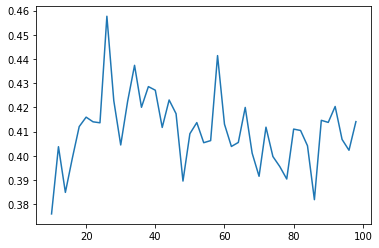

In [ ]:
plt.plot(testdf["topic"], testdf["score"])
plt.xtick("Number ")

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=27, id2word=dictionary, passes=20, workers=4, chunksize=100)

# topics with their words

In [ ]:
get_lda_topics(lda_model_tfidf, 27)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25,Topic # 26,Topic # 27
0,nois,gaussian,translat,inspect,offlin,organis,instal,region,titl,sensor,...,bit,chatbot,prefer,child,imagenet,annot,neuron,crazi,presid,pool
1,watson,philosophi,hous,water,speech,ensembl,gpus,bound,trust,vote,...,pseudo,messag,favor,symbol,young,women,interview,child,markov,incom
2,recip,earth,pixel,land,alphago,centr,card,mask,polit,william,...,chunk,custom,https,planet,talent,attract,tabl,children,chain,percent
3,cook,quantum,letter,song,assist,mode,desktop,box,bank,handwritten,...,messag,bot,coordin,fiction,passion,float,agent,innov,statement,baidu
4,pretrain,decemb,sentenc,lose,neuron,parti,cuda,segment,enterpris,snippet,...,scikit,app,descent,room,analyt,facial,reward,sake,hinton,fourth
5,ingredi,distribut,pool,reli,seed,analys,cpus,entropi,wave,earth,...,boost,social,comparison,tag,http,pretrain,devic,stem,relationship,diagram
6,weak,fiction,phrase,terribl,screenshot,percept,ensembl,propos,startup,bound,...,kaggl,job,varianc,netflix,microsoft,selfi,star,steve,transcript,chines
7,boost,ship,synaps,bit,lstm,rent,netflix,pixel,secur,formal,...,competit,player,coeffici,send,dictionari,hair,sequenc,junk,cnns,batch
8,tast,planet,relationship,threat,html,plus,retrain,distribut,ture,simul,...,competitor,voic,irrelev,chines,edit,wear,batch,prime,represent,educ
9,eleg,civil,semant,simul,netflix,compris,scikit,outcom,hello,maxim,...,forum,simul,outlier,dark,distanc,camera,price,manufactur,hierarch,speech


In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"nois" + 0.017*"watson" + 0.016*"recip" + 0.010*"cook" + 0.009*"pretrain" + 0.008*"ingredi" + 0.006*"weak" + 0.006*"boost" + 0.005*"tast" + 0.005*"eleg"
Topic: 1 
Words: 0.012*"gaussian" + 0.005*"philosophi" + 0.005*"earth" + 0.004*"quantum" + 0.004*"decemb" + 0.003*"distribut" + 0.001*"fiction" + 0.001*"ship" + 0.001*"planet" + 0.001*"civil"
Topic: 2 
Words: 0.013*"translat" + 0.012*"hous" + 0.010*"pixel" + 0.009*"letter" + 0.009*"sentenc" + 0.008*"pool" + 0.007*"phrase" + 0.007*"synaps" + 0.007*"relationship" + 0.007*"semant"
Topic: 3 
Words: 0.001*"inspect" + 0.001*"water" + 0.001*"land" + 0.001*"song" + 0.001*"lose" + 0.001*"reli" + 0.001*"terribl" + 0.001*"bit" + 0.001*"threat" + 0.001*"simul"
Topic: 4 
Words: 0.001*"offlin" + 0.001*"speech" + 0.001*"alphago" + 0.001*"assist" + 0.001*"neuron" + 0.001*"seed" + 0.001*"screenshot" + 0.001*"lstm" + 0.001*"html" + 0.001*"netflix"
Topic: 5 
Words: 0.001*"organis" + 0.001*"ensembl" + 0.001*"centr" + 0.001*"mode" + 

In [ ]:
lda_model_tfidf.save('model10.gensim')
topics = lda_model_tfidf.print_topics(num_words=6)
for topic in topics:
    print(topic)

(9, '0.005*"sensor" + 0.004*"vote" + 0.003*"william" + 0.003*"handwritten" + 0.003*"snippet" + 0.003*"earth"')
(26, '0.001*"pool" + 0.001*"incom" + 0.001*"percent" + 0.001*"baidu" + 0.001*"fourth" + 0.001*"diagram"')
(19, '0.013*"prefer" + 0.007*"favor" + 0.004*"https" + 0.001*"coordin" + 0.001*"descent" + 0.001*"comparison"')
(1, '0.012*"gaussian" + 0.005*"philosophi" + 0.005*"earth" + 0.004*"quantum" + 0.004*"decemb" + 0.003*"distribut"')
(15, '0.023*"music" + 0.016*"song" + 0.010*"handwritten" + 0.006*"echo" + 0.006*"endless" + 0.004*"alex"')
(24, '0.009*"crazi" + 0.008*"child" + 0.008*"children" + 0.007*"innov" + 0.005*"sake" + 0.003*"stem"')
(17, '0.006*"bit" + 0.004*"pseudo" + 0.001*"chunk" + 0.001*"messag" + 0.001*"scikit" + 0.001*"boost"')
(11, '0.024*"page" + 0.012*"height" + 0.011*"column" + 0.010*"relationship" + 0.010*"behaviour" + 0.009*"visualis"')
(12, '0.008*"tast" + 0.007*"forest" + 0.003*"ensembl" + 0.003*"eleg" + 0.003*"strict" + 0.003*"formul"')
(10, '0.033*"cheat" 

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# VISUALISATION OF THE TOPICS

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf, corpus_tfidf, dictionary, mds="mmds", R=10)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23    -0.241316  0.060504       1        1  42.463252
18     0.020490  0.285076       2        1  20.414802
2     -0.006244 -0.286997       3        1  14.855011
8      0.189833 -0.105691       4        1   5.115692
6      0.147479  0.049431       5        1   2.706327
7      0.021966  0.089560       6        1   1.447005
11     0.029744 -0.060605       7        1   1.245947
22     0.059454  0.017744       8        1   1.206410
13    -0.058024 -0.001732       9        1   1.047665
0     -0.035692 -0.020694      10        1   0.817433
10    -0.020730 -0.039048      11        1   0.801557
15    -0.006588 -0.019041      12        1   0.625211
16    -0.018505  0.006580      13        1   0.587126
24    -0.013034  0.011607      14        1   0.579468
21    -0.003181  0.010026      15        1   0.520340
1     -0.005116 -0.003961      16        1   0.507156
12    -0.002069 -0.001399      17        1   0.501657
9     -0.005757  0.003393      18        1   0.484926
19    -0.001707  0.002538      19        1   0.483534
17    -0.007577  0.000308      20        1   0.470750
3     -0.006205  0.000357      21        1   0.445533
25    -0.006217  0.000346      22        1   0.445533
5     -0.006133  0.000299      23        1   0.445533
4     -0.006214  0.000339      24        1   0.445533
20    -0.006218  0.000356      25        1   0.445533
14    -0.006222  0.000367      26        1   0.445533
26    -0.006215  0.000336      27        1   0.445533, topic_info=         Term      Freq     Total Category  logprob  loglift
673     pixel  5.000000  5.000000  Default  10.0000  10.0000
656    instal  3.000000  3.000000  Default   9.0000   9.0000
26    chatbot  5.000000  5.000000  Default   8.0000   8.0000
1336    music  2.000000  2.000000  Default   7.0000   7.0000
460    neuron  9.000000  9.000000  Default   6.0000   6.0000
...       ...       ...       ...      ...      ...      ...
1442   chines  0.006532  1.044588  Topic27  -7.4567   0.3390
629   diagram  0.006542  2.372557  Topic27  -7.4551  -0.4798
922      educ  0.006511  2.149770  Topic27  -7.4600  -0.3860
509     batch  0.006514  4.440725  Topic27  -7.4594  -1.1109
203    speech  0.006488  3.942262  Topic27  -7.4635  -0.9959

[455 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
407       3  0.890863      advic
500       1  0.917967      agent
501       3  0.833695    alphago
703       1  0.826479     analyt
984       8  0.723103      annot
...     ...       ...        ...
1738      2  0.989299       weak
1753      2  0.665151       wear
1121      3  0.698589  wikipedia
1566      8  0.638318      women
1084      4  1.053358      young

[205 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 19, 3, 9, 7, 8, 12, 23, 14, 1, 11, 16, 17, 25, 22, 2, 13, 10, 20, 18, 4, 26, 6, 5, 21, 15, 27])

Performance evaluation by classifying sample document using LDA Bag of Words model

# SEEING THE TOPIC ALLOCATED TO DOC NUMBER 300

In [ ]:
for index, score in sorted(lda_model_tfidf[corpus[300]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5042006969451904	 
Topic: 0.009*"neuron" + 0.006*"interview" + 0.006*"tabl" + 0.005*"agent" + 0.005*"reward" + 0.004*"devic" + 0.004*"star" + 0.004*"sequenc" + 0.004*"batch" + 0.004*"price"

Score: 0.25733682513237	 
Topic: 0.011*"chatbot" + 0.007*"messag" + 0.006*"custom" + 0.006*"bot" + 0.006*"app" + 0.006*"social" + 0.006*"job" + 0.006*"player" + 0.006*"voic" + 0.005*"simul"

Score: 0.13824401795864105	 
Topic: 0.024*"page" + 0.012*"height" + 0.011*"column" + 0.010*"relationship" + 0.010*"behaviour" + 0.009*"visualis" + 0.007*"mnist" + 0.007*"extract" + 0.007*"caff" + 0.006*"nod"

Score: 0.08854670822620392	 
Topic: 0.013*"translat" + 0.012*"hous" + 0.010*"pixel" + 0.009*"letter" + 0.009*"sentenc" + 0.008*"pool" + 0.007*"phrase" + 0.007*"synaps" + 0.007*"relationship" + 0.007*"semant"


# COHERENCE SCORE

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4319890072649489


# NMF

# FINDING BEST NUMBER OF TOPICS FOR NMF

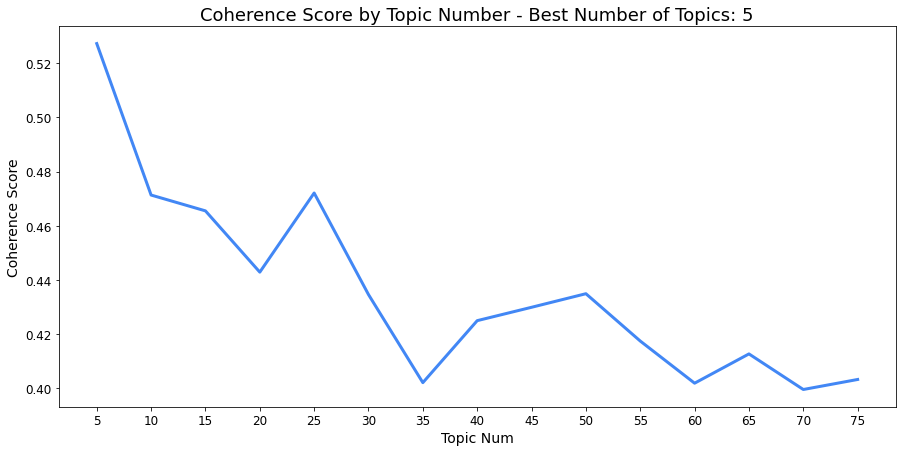

In [ ]:
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=100,
        passes=20,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)


plt.show()

In [ ]:
# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf2 = tfidf_vectorizer.fit_transform(docs)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    # n_components=best_num_topics,
    n_components=5,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    # alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf2)

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/saved_model/finalized_tfidf_vectorizer.sav'
pickle.dump(tfidf_vectorizer, open(filename, 'wb'))

# TOPICS WITH THEIR WORDS

In [ ]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(docs))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,topics
0,network,neural,layer,neural network,neuron,train,weight,output,network neural layer neuron train weight output
1,machin,human,intellig,data,machin learn,system,peopl,technolog,machin human intellig data learn system peopl ...
2,action,tabl,reward,polici,state,network,valu,agent,action tabl reward polici state network valu a...
3,imag,object,model,region,pixel,train,bound,featur,imag object model region pixel train bound featur
4,instal,gpus,card,lane,model,cuda,motherboard,cpus,instal gpus card lane model cuda motherboard cpus


In [ ]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,network neural layer neuron train weight output
1,1,machin human intellig data learn system peopl ...
2,2,action tabl reward polici state network valu a...
3,3,imag object model region pixel train bound featur
4,4,instal gpus card lane model cuda motherboard cpus


In [ ]:
topic_df.to_csv("/content/drive/MyDrive/Colab Notebooks/saved_model/topics_data.csv")

# COHERENCE OF NMF

In [ ]:
nmf2 = Nmf(
        corpus=corpus,
        num_topics=5,
        id2word=dictionary,
        chunksize=100,
        passes=20,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

cm = CoherenceModel(
        model=nmf2,
        texts=docs,
        dictionary=dictionary,
        coherence='c_v'
    )

print("Coherence Score", cm.get_coherence())

Coherence Score 0.5272026853563941


# ALLOCATING TOPICS TO ARTICLES

In [ ]:
# Creating a temp df with the url and topic num to join on
docid = df['docid'].tolist()

df_temp = pd.DataFrame({
    'docid': docid,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='docid',
    how='left'
)

# df_topics = df_topics.drop(
#     'processed_text',
#     axis=1
# )

df_topics

,docid,doc,topic_num,topics
0,0,"['headlin', 'blare', 'chatbot', 'next', 'thing...",1,machin human intellig data learn system peopl ...
1,1,"['ever', 'find', 'look', 'question', 'concept'...",1,machin human intellig data learn system peopl ...
2,2,"['machin', 'learn', 'increas', 'move', 'hand',...",2,action tabl reward polici state network valu a...
3,3,"['understand', 'machin', 'learn', 'question', ...",1,machin human intellig data learn system peopl ...
4,4,"['want', 'learn', 'appli', 'artifici', 'intell...",2,action tabl reward polici state network valu a...
...,...,...,...,...
332,332,"['click', 'share', 'articl', 'linkedin', 'skip...",0,network neural layer neuron train weight output
333,333,"['opinion', 'deep', 'neural', 'network', 'mach...",0,network neural layer neuron train weight output
334,334,"['everyon', 'remot', 'tune', 'recent', 'progre...",0,network neural layer neuron train weight output
335,335,"['biggest', 'misconcept', 'around', 'idea', 'd...",0,network neural layer neuron train weight output


# ORIGINAL MATRIX A
# W has the topics
# H has the weights of the topics

In [ ]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(docs)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 337 x 5000
W = 5 x 5000
H = 337 x 5


In [ ]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 317.748'

# TOPIC WISE RESIDUALS
# CLOSER TO 0 BETTER

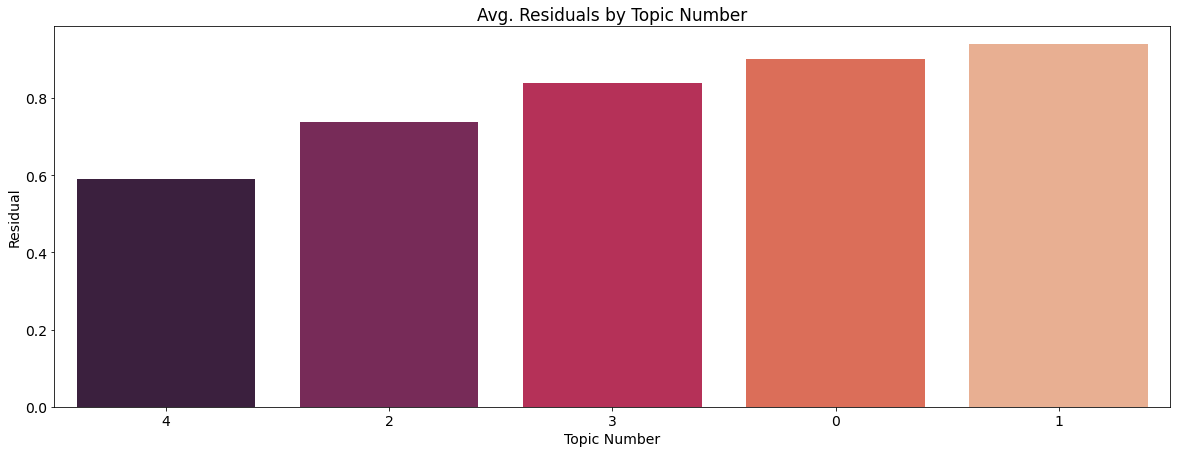

In [ ]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)



plt.show()

In [ ]:
testdocs=["Machine learning is a very important domain of study and can help solve real life problems",
          "The state government is imposing restrictions from tomorrow", 
          "The natural language process consists of the training and testing phases", 
          ]

In [ ]:
for i in testdocs:
  i=[preprocess(i)]
  testweight = nmf.transform(tfidf_vectorizer.transform(i))
  # topic_df["topics"][testweight.argmax(axis=1)[0]]
  print(topic_df["topics"][[testweight.argmax(axis=1)][0]])

1    machin human intellig data learn system peopl ...
Name: topics, dtype: object
2    action tabl reward polici state network valu a...
Name: topics, dtype: object
1    machin human intellig data learn system peopl ...
Name: topics, dtype: object


In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/saved_model/finalized_model.sav'
pickle.dump(nmf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/saved_model/finalized_model.sav', 'rb'))
loaded_vectorizer=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/saved_model/finalized_tfidf_vectorizer.sav', 'rb'))
i=[preprocess("Machine learning is a very important domain of study and can help solve real life problems")]
testweight = loaded_model.transform(loaded_vectorizer.transform(i))

In [ ]:
topic_df["topics"][testweight.argmax(axis=1)[0]]

'machin human intellig data learn system peopl technolog'

# **creating real time topic modeller**

In [ ]:
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/saved_model/finalized_model.sav', 'rb'))
loaded_vectorizer=pickle.load(open('/content/drive/MyDrive/Colab Notebooks/saved_model/finalized_tfidf_vectorizer.sav', 'rb'))
topic_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/saved_model/topics_data.csv")
while(1):
    doc=input("Enter doc: ")
    doc=[preprocess(doc)]
    testweight = loaded_model.transform(loaded_vectorizer.transform(doc))
    print("Topic: ",topic_df["topics"][testweight.argmax(axis=1)[0]], "\n")


Enter doc: Machine learning is a very important domain of study and can help solve real life problems
Topic:  machin human intellig data learn system peopl technolog 

Enter doc: The state government is imposing restrictions from tomorrow
Topic:  action tabl reward polici state network valu agent 

Enter doc: nueral network is nice
Topic:  network neural layer neuron train weight output 

Enter doc: train your model
Topic:  instal gpus card lane model cuda motherboard cpus 

Enter doc: computer is important
Topic:  machin human intellig data learn system peopl technolog 

Enter doc: computer is slow because of its age
Topic:  machin human intellig data learn system peopl technolog 

Enter doc: computer is slow
Topic:  machin human intellig data learn system peopl technolog 

Enter doc: processor is slow 
Topic:  instal gpus card lane model cuda motherboard cpus 



KeyboardInterrupt: ignored

# **Article Recommendation**

In [ ]:
words_list=list(chain.from_iterable(docs))

In [ ]:
# Cosine similarity
def cosine_sim(text1, text2):
    tfidf_score = TfidfVectorizer().fit_transform([text1, text2])
    return ((tfidf_score * tfidf_score.T).A)[0, 1]

# Most similar article
def closest_doc_name(sentence, docs):
    cos = []
    for i in range(len(docs)):
        cos.append(cosine_sim(', '.join(sentence.split(' ')),', '.join(docs[i])))
    return [titles[x] for x in np.argsort(cos)[-10:][::-1]]

In [ ]:
closest_doc_name('sports', docs)

['“WTH does a neural network even learn??” — a newcomer’s dilemma',
 'I scheduled 1,019 meetings in 2012 — and that doesn’t count reschedules — x.ai',
 'Formalizing indirect normativity – AI Alignment',
 'Emotional Computing – Robbie Tilton – Medium',
 'Becoming a Cyborg should be taken gently: Of Modern Bio-Paleo-Machines — Cyborgology',
 'why you just can’t black box an a.i. – [ weird things ]',
 'why do we want to build a fully fledged a.g.i.? – [ weird things ]',
 'New to Machine Learning? Avoid these three mistakes',
 'Classifying Websites with Neural Networks – Knowledge from Data: The Datafiniti Blog',
 'Is there a future for innovation ? – Becoming Human: Artificial Intelligence Magazine']